Final Project 
======

Kaggle Competition 
-----

For this project I chose to do the active competition [San Francisco Crime Classification](https://www.kaggle.com/c/sf-crime/). I'll test out a number of different algorithms with test data. I am interested in this type of analysis as it is data science that contributes to the common good.

### Setup

In [22]:
# Pandas and numpy
import pandas as pd
import numpy as np

# Python functions
from dateutil.relativedelta import *
from datetime import datetime
import re, math

# Patsy 
from patsy import dmatrices

# sklearn functions
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import OneHotEncoder, Imputer, Normalizer
from sklearn.preprocessing import LabelEncoder, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report\
                        , f1_score, accuracy_score 
from sklearn.feature_selection import SelectKBest\
                        , SelectPercentile, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.decomposition import PCA\
                                , TruncatedSVD  #for sparse matrices
from sklearn.cluster import KMeans
from sklearn.grid_search import GridSearchCV 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import AdaBoostClassifier

# matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

# Make plots BIG
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 12, 8

# GIS functionality
from mpl_toolkits.basemap import Basemap, cm
import cartopy.io.shapereader as shpreader
import fiona
import pysal 
from pyproj import Proj
from pysal.cg.shapes import Point
from pysal.cg.locators import PolygonLocator, PointLocator, BruteForcePointLocator 
from pysal.cg.sphere import arcdist

# Multiprocessing 
import multiprocessing

# Logging
import logging
FORMAT = '%(asctime)-15s %(message)s'
logging.basicConfig(format=FORMAT)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

In [23]:
class MultiColumnLabelEncoder:
    ''' Create a class that encodes
        labels for a matrix of data
    '''
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here
    
    def get_params(self, deep=True):
        out = dict()
        if self.columns: out['columns'] = columns
        return out

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). 
        '''
        numerics = [np.float16, np.float32, np.float64]
        ints = [np.int16, np.int32, np.int64]
        output = X.copy()
        '''
        if self.columns is not None:
            for col in self.columns:
                if col.dtype not in numerics+ints:
                    output[col] = LabelEncoder().fit_transform(output[col])
                elif col.dtype not in ints:
                    output[col] = scale(output[col])
        else:
        '''
        try:
            for colname,col in output.iteritems():
                if col.dtype not in numerics+ints:
                    # Turn text columns into ints
                    output[colname] = LabelEncoder().fit_transform(output[colname])
                elif col.dtype in numerics:
                    # handle floats with scaling
                    mn = np.mean(output[colname])
                    output[colname] = output[colname].fillna(mn)
                    output[colname] = scale(output[colname])
                elif col.dtype in ints:
                    pass # leave integers alone
        except:
            output = LabelEncoder().fit_transform(output)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [24]:
train_raw = pd.read_csv('Data/train.csv')
test_raw = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sampleSubmission.csv')
print train_raw.shape

(878049, 9)


### Part 1: Submit first (bad) try

In [25]:
test_raw.head()

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412


In [26]:
sample_submission.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [27]:
train_data\
,train_labels = train_raw[['DayOfWeek'\
                                     ,'PdDistrict'\
                                     ,'Address'\
                                     ,'X'\
                                     ,'Y']][2001:]\
                            ,train_raw['Category'][2001:]
dev_data\
,dev_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][:1000]\
                            ,train_raw['Category'][:1000]
dev_test_data\
,dev_test_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][1001:2000]\
                            ,train_raw['Category'][1001:2000]
test_data = test_raw[['DayOfWeek'\
                     ,'PdDistrict'\
                     ,'Address'\
                     ,'X'\
                     ,'Y']]

In [28]:
rf = RandomForestClassifier() #leaving with default settings for now

##### Data needs to be preprocessed for RF in sklearn

In [29]:
def recode(df):
    numerics = ['float16', 'float32', 'float64']
    ints = ['int16', 'int32', 'int64']
    for i in range(df.shape[1]):
        t = df.iloc[:,i].dtype
        if t not in numerics or ints:
            le = LabelEncoder()
            le.fit(df.iloc[:,i])
            df.iloc[:,i] = le.transform(df.iloc[:,i])
        elif t not in ints:
            df.iloc[:,i] = scale(df.iloc[:,i])
    return df

def recode_labels(df):
    le = LabelEncoder()
    le.fit(df)
    return le

In [30]:
dev_data = recode(dev_data)
dev_label_le = recode_labels(np.concatenate((dev_labels,dev_test_labels),axis=1))
dev_labels = dev_label_le.transform(dev_labels)
dev_test_data = recode(dev_test_data)
dev_test_labels = dev_label_le.transform(dev_test_labels)

##### Run model

In [31]:
rf.fit(dev_data,dev_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
predictions = rf.predict(dev_test_data)

In [33]:
actual_predictions = dev_label_le.inverse_transform(predictions)
actual_labels = dev_label_le.inverse_transform(dev_test_labels)
print actual_predictions[:5],'\n',actual_labels[:5]

['LARCENY/THEFT' 'LARCENY/THEFT' 'NON-CRIMINAL' 'NON-CRIMINAL'
 'NON-CRIMINAL'] 
['OTHER OFFENSES' 'LARCENY/THEFT' 'LARCENY/THEFT' 'WARRANTS' 'WARRANTS']


In [34]:
accuracy = np.sum((actual_predictions == actual_labels)*1.0)/len(dev_labels)
print 'Dev Accuracy: {0}%'.format(accuracy*100)

Dev Accuracy: 21.1%


##### Train with real data

In [35]:
train_data, test_data = recode(train_data), recode(test_data)
train_le = recode_labels(train_labels)
train_labels = train_le.transform(train_labels)

/Library/Python/2.7/site-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [36]:
rf = RandomForestClassifier()
rf.fit(train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

##### Make predictions and format for submission

In [37]:
predictions = rf.predict(test_data)
actual_predictions = train_le.inverse_transform(predictions)

In [38]:
l = len(test_data)
submission = np.zeros((l,40),dtype=np.int32)
submission[:,0] = range(l)
cols = train_le.classes_ 
for i,c in enumerate(cols):
    submission[:,i+1] = actual_predictions == c

In [39]:
submission_cols = ['Id']
submission_cols.extend(cols)
submission_df = pd.DataFrame(submission,columns=submission_cols)
submission_df.head()

,Id,ARSON,ASSAULT,BAD CHECKS,BRIBERY,BURGLARY,DISORDERLY CONDUCT,DRIVING UNDER THE INFLUENCE,DRUG/NARCOTIC,DRUNKENNESS,...,SEX OFFENSES NON FORCIBLE,STOLEN PROPERTY,SUICIDE,SUSPICIOUS OCC,TREA,TRESPASS,VANDALISM,VEHICLE THEFT,WARRANTS,WEAPON LAWS
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Save data to csv file for submission

In [40]:
submission_df.to_csv('Data/submission_file1.csv',index=False)

First attempt: Rank 208, score 26.95890, tested accuracy of ~20%.

#### Analyze errors

In [41]:
dev_test_data\
,dev_test_labels = train_raw[['DayOfWeek'\
                                 ,'PdDistrict'\
                                 ,'Address'\
                                 ,'X'\
                                 ,'Y']][1001:2000]\
                            ,train_raw['Category'][1001:2000]
dev_test_data = recode(dev_test_data)
predictions = rf.predict(dev_test_data)
actual_predictions = train_le.inverse_transform(predictions)

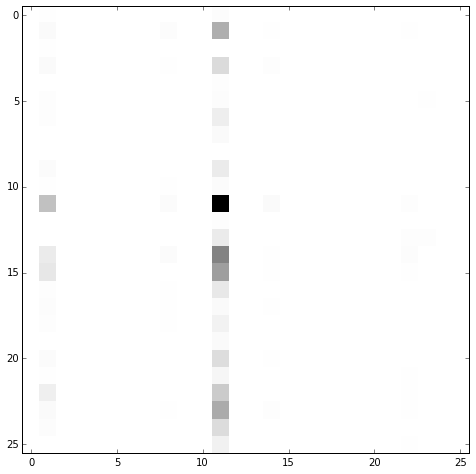

In [42]:
conf = confusion_matrix(dev_test_labels,actual_predictions)
plt.imshow(conf, cmap='binary',interpolation='nearest')

In [43]:
pd.crosstab(dev_test_labels, actual_predictions, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,ASSAULT,FORGERY/COUNTERFEITING,LARCENY/THEFT,NON-CRIMINAL,VANDALISM,VEHICLE THEFT,All
True,,,,,,,
ARSON,1,0,3,0,0,0,4
ASSAULT,5,3,69,1,1,0,79
BRIBERY,1,0,0,0,0,0,1
BURGLARY,5,1,31,2,0,0,39
DISORDERLY CONDUCT,0,0,2,0,0,0,2
DRIVING UNDER THE INFLUENCE,2,0,3,0,0,1,6
DRUG/NARCOTIC,2,0,15,0,0,0,17
DRUNKENNESS,0,0,5,0,0,0,5
FRAUD,4,0,17,0,0,0,21


Since samples are not weighted well in terms of categories, the model seems to be having difficulties with categories that have a larger amount of observations - likely because all of the conditions used to predict crimes are seen more frequently for the samples with more observations. For example, there is no predictions that are Liqour Law because this is an infrequent category in the training data. To make the model generalize better it will be necessary to resample the dataset so that possible outcomes are represented more evenly. 

### Part 2: Tests to increase accuracy

##### Reload data

In [44]:
logger.info('Load of data started')
# train_raw = pd.read_csv('Data/train.csv')
train_raw = pd.read_csv('/Users/bshur/School/Machine Learning/\
Final Project/Data/SFPD_Incidents_-_from_1_January_2003.csv')
train_raw['Dates'] = pd.to_datetime(train_raw['Date']\
                                 +' '\
                                 +train_raw['Time']\
                                 ,format='%m/%d/%Y %H:%M')
test_raw = pd.read_csv('Data/test.csv')
sample_submission = pd.read_csv('Data/sampleSubmission.csv')
logger.info('Load of data finished')
print train_raw.shape

INFO:root:Load of data started
INFO:root:Load of data finished


(1792667, 14)


##### Deep dive into crimes dataset

In [45]:
print train_raw.groupby(['Category']).size()

Category
ARSON                            3109
ASSAULT                        157056
BAD CHECKS                        831
BRIBERY                           623
BURGLARY                        75176
DISORDERLY CONDUCT               8600
DRIVING UNDER THE INFLUENCE      4693
DRUG/NARCOTIC                  108571
DRUNKENNESS                      8677
EMBEZZLEMENT                     2486
EXTORTION                         581
FAMILY OFFENSES                  1045
FORGERY/COUNTERFEITING          21346
FRAUD                           34196
GAMBLING                          292
KIDNAPPING                       4694
LARCENY/THEFT                  360680
LIQUOR LAWS                      3760
LOITERING                        2331
MISSING PERSON                  52706
NON-CRIMINAL                   189080
OTHER OFFENSES                 256504
PORNOGRAPHY/OBSCENE MAT            45
PROSTITUTION                    15289
RECOVERED VEHICLE                6346
ROBBERY                         46534
RUN

In [46]:
def show_descripts(cat,first_n=10):
    ''' A function to evaluate descriptions for a category 
        sorted by the number of crimes
    '''
    g = train_raw[train_raw['Category']==cat]\
        [['Category','Descript']]\
        .groupby(['Category','Descript']).agg(len)
    for x in sorted(zip(g.index,g.values),key=lambda x: x[1], reverse=True)[:first_n]:
        print x

show_descripts('SUSPICIOUS OCC')

(('SUSPICIOUS OCC', 'SUSPICIOUS OCCURRENCE'), 44576)
(('SUSPICIOUS OCC', 'INVESTIGATIVE DETENTION'), 12077)
(('SUSPICIOUS OCC', 'SUSPICIOUS PERSON'), 4021)
(('SUSPICIOUS OCC', 'SUSPICIOUS ACT TOWARDS FEMALE'), 1503)
(('SUSPICIOUS OCC', 'SUSPICIOUS OCCURRENCE, POSSIBLE SHOTS FIRED'), 795)
(('SUSPICIOUS OCC', 'SUSPICIOUS ACT TOWARDS CHILD'), 568)
(('SUSPICIOUS OCC', 'UNUSUAL OCCURENCE'), 361)
(('SUSPICIOUS OCC', 'SUSPICIOUS AUTO, POSSIBLY SEX'), 339)


I've noticed that categories aren't the best at describing the data in terms a model would understand. Some categories have a lot of crimes included that would make it difficult to have an accurate model, no matter what supplemental data sources are attached to the training set. Below I am looking to create a smaller number of 'meta-categories' that will be easier to predict by grouping individual categories and by including individual descriptions into appropriate meta-categories that will be easier for a model to interpret. 

After re-classifying the crimes for the training set, I will attempt to build a prediction model that will be used to predict meta-categories for the test set - which will then be utilized as an additional feature in the final model.

In [47]:
def collar_crimes(x,y):
    ''' Add a meta category for 
        crimes based on the skills
        required
    '''
    blue_collar_violent = [ 
                   "ASSAULT"
                   , "KIDNAPPING"
                   , "ARSON"
                   , 'DOMESTIC VIOLENCE'
                   , 'GANG ACTIVITY'
                  ]
    blue_collar_other = [
                "VANDALISM"
                ,"DISORDERLY CONDUCT"
                ,"TRESPASS"
                ,'TREA'
               , 'LOITERING'
                ,'RESISTING ARREST'
                ,'PROBATION VIOLATION'
                ,'PROBATION VIOLATION'
                ,'VIOLATION OF RESTRAINING ORDER'
                ,'PAROLE VIOLATION'
    ]
    sex_crimes = [
            'SEX OFFENSES FORCIBLE',
            'PORNOGRAPHY/OBSCENE MAT',
            'SEX OFFENSES NON FORCIBLE',
            'PROSTITUTION'
        ]
    alcohol = [
        'DRIVING UNDER THE INFLUENCE',
        'DRUNKENNESS',
        'LIQUOR LAWS'
    ]
    drug = ['DRUG/NARCOTIC']
    theft = [
        'LARCENY/THEFT',
         'STOLEN PROPERTY',
         "ROBBERY",
         'CREDIT CARD, THEFT BY USE OF',
        'FRAUDULENT USE OF AUTOMATED TELLER CARD',
        'BURGLARY'
    ]
    vehicle = [
        'RECOVERED VEHICLE',
        'VEHICLE THEFT',
        'DRIVERS LICENSE, SUSPENDED OR REVOKED',
        'TRAFFIC VIOLATION',
        'TRAFFIC VIOLATION ARREST',
        'DRIVERS LICENSE, SUSPENDED OR REVOKED',
        'LOST/STOLEN LICENSE PLATE',
        'IMPOUNDED VEHICLE',
        'TRAFFIC ACCIDENT',
        'MALICIOUS MISCHIEF, VANDALISM OF VEHICLES'
    ]
    noncrime = [
        'MISSING PERSON',
        'RUNAWAY',
        'SUICIDE',
        'NON-CRIMINAL',
        'SUSPICIOUS OCC'
    ]
    white_collar = [ 
        "FRAUD"
       , "FORGERY/COUNTERFEITING"
       , "BAD CHECKS" 
       , "EXTORTION"
       , "EMBEZZLEMENT"
       , "BRIBERY"
        , 'CONSPIRACY'
    ]
    if x in blue_collar_violent or y in blue_collar_violent: return 1
    elif x in sex_crimes or y in sex_crimes: return 2
    elif x in alcohol or y in alcohol: return 3
    elif x in drug or y in drug: return 4
    elif x in theft or y in theft: return 5
    elif x in vehicle or y in vehicle: return 6
    elif x in noncrime or y in noncrime: return 7
    elif x in white_collar or y in white_collar: return 8
    elif x in blue_collar_other or y in blue_collar_other: return 9
    else: return 10
collar_crimes = np.vectorize(collar_crimes,otypes=[np.int64])
logger.info('Creation of collar_id started')
train_raw['collar_id'] = collar_crimes(train_raw['Category'],train_raw['Descript'])
logger.info('Creation of collar_id ended')

INFO:root:Creation of collar_id started
INFO:root:Creation of collar_id ended


In [48]:
def show_newcategories(col,first_n=10):
    ''' Evaluate how crimes are fit into the new 
        categories defined above
    '''
    g = train_raw[train_raw['collar_id']==col]\
        [['Category','Descript']]\
        .groupby(['Category','Descript']).agg(len)
    for x in sorted(zip(g.index,g.values),key=lambda x: x[1], reverse=True)[:first_n]:
        print x

show_newcategories(1)

(('ASSAULT', 'BATTERY'), 55918)
(('ASSAULT', 'THREATS AGAINST LIFE'), 29889)
(('SECONDARY CODES', 'DOMESTIC VIOLENCE'), 15133)
(('ASSAULT', 'INFLICT INJURY ON COHABITEE'), 14612)
(('ASSAULT', 'AGGRAVATED ASSAULT WITH A DEADLY WEAPON'), 13192)
(('ASSAULT', 'AGGRAVATED ASSAULT WITH BODILY FORCE'), 10109)
(('ASSAULT', 'BATTERY, FORMER SPOUSE OR DATING RELATIONSHIP'), 5601)
(('ASSAULT', 'AGGRAVATED ASSAULT WITH A KNIFE'), 4998)
(('KIDNAPPING', 'FALSE IMPRISONMENT'), 2856)
(('ASSAULT', 'CHILD ABUSE (PHYSICAL)'), 2737)


Another thing I've noticed is how some categories have minimal amounts of crimes which makes it difficult to build a model because there is such a strong bias in predicting crimes that occur the most often. I am creating a sampling methodology that samples with replacement in order to gather a more even amount of observations in each dataset.  

In [49]:
# Gather counts of each category 
g = train_raw[['Category','Descript']].groupby(['Category']).agg(len)
group_cnts = pd.DataFrame({'Category':np.array(g.index).T,'Value':np.array(g.T)[0]})
print group_cnts

                       Category   Value
0                         ARSON    3109
1                       ASSAULT  157056
2                    BAD CHECKS     831
3                       BRIBERY     623
4                      BURGLARY   75176
5            DISORDERLY CONDUCT    8600
6   DRIVING UNDER THE INFLUENCE    4693
7                 DRUG/NARCOTIC  108571
8                   DRUNKENNESS    8677
9                  EMBEZZLEMENT    2486
10                    EXTORTION     581
11              FAMILY OFFENSES    1045
12       FORGERY/COUNTERFEITING   21346
13                        FRAUD   34196
14                     GAMBLING     292
15                   KIDNAPPING    4694
16                LARCENY/THEFT  360680
17                  LIQUOR LAWS    3760
18                    LOITERING    2331
19               MISSING PERSON   52706
20                 NON-CRIMINAL  189080
21               OTHER OFFENSES  256504
22      PORNOGRAPHY/OBSCENE MAT      45
23                 PROSTITUTION   15289


##### Add time of day 

Since a timestamp is not good for the generalization of the model, attempt bucketing of hours within each day, and break off day of month and year of crime and separate dimensions. 

In [50]:
ceil = np.vectorize(math.ceil)
    
logger.info('Datetime conversion started')
train_raw['Dates'] = pd.to_datetime(train_raw['Dates'])
test_raw['Dates'] = pd.to_datetime(test_raw['Dates'])

logger.info('DaySegment creation started')
train_raw['DaySegment'] = ceil((train_raw['Dates'].dt.hour+1)/4).astype(np.int)
test_raw['DaySegment'] = ceil((test_raw['Dates'].dt.hour+1)/4).astype(np.int)

logger.info('TimeOfDay creation started')
train_raw['TimeOfDay'] = train_raw['Dates'].dt.hour
test_raw['TimeOfDay'] = test_raw['Dates'].dt.hour

logger.info('DayOfMonth creation started')
train_raw['DayOfMonth'] = train_raw['Dates'].dt.day
test_raw['DayOfMonth'] = test_raw['Dates'].dt.day

logger.info('Year creation started')
train_raw['Year'] = train_raw['Dates'].dt.year
test_raw['Year'] = test_raw['Dates'].dt.year

logger.info('Month creation started')
train_raw['Month'] = train_raw['Dates'].dt.month
test_raw['Month'] = test_raw['Dates'].dt.month

logger.info('YearQtr creation started')
train_raw['YearQtr'] = train_raw['Dates'].dt.year*100\
    +ceil(train_raw['Dates'].dt.month/4).astype(np.int)
test_raw['YearQtr'] = test_raw['Dates'].dt.year*100\
    +ceil(test_raw['Dates'].dt.month/4).astype(np.int)

logger.info('YearSegment creation started')
train_raw['YearSegment'] = ceil(train_raw['Dates'].dt.month/4).astype(np.int)
test_raw['YearSegment'] =  ceil(test_raw['Dates'].dt.month/4).astype(np.int)
logger.info('Date feature processing ended')

INFO:root:Datetime conversion started
INFO:root:DaySegment creation started
INFO:root:TimeOfDay creation started
INFO:root:DayOfMonth creation started
INFO:root:Year creation started
INFO:root:Month creation started
INFO:root:YearQtr creation started
INFO:root:YearSegment creation started
INFO:root:Date feature processing ended


##### Add clustering based on lat/lon and time of day

Currently, by using the exact location of the crime, the model does not generalize very well. I KMeans to segment training data into clusters based on location, time of day, and year and add both the cluster label and distance from centroid as features.

In [51]:
def test_clusters(range_n_clusters,fields=['X','Y','YearSegment','Year']):
    km_models = []
    i_scores = []
    tr = train_raw[fields].copy()
    tr = le.fit_transform(tr)
    for n_clusters in range(range_n_clusters):
        logger.info('Cluster {} started'.format(n_clusters))
        if n_clusters>1:
            km = KMeans(n_clusters=n_clusters, random_state=5)
            km.fit(tr)
            km_models.append(km)
            inertia = km.inertia_ 
            print 'For {0}, inertia = {1}'.format(
                n_clusters, inertia
            )
            i_scores.append(inertia)
       
    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('KMeans inertia values')
    ax.set_xlabel('Clusters')
    ax.set_ylabel('Inertia')
    ax.plot([i for i in range(range_n_clusters) \
             if i>1],i_scores,'-', linewidth=2)
    plt.show()
    
#test_clusters(25)

Because of the clustering process, I found that there are a few points with what must be default values of lat/lon coordinates: 90,-120.5. Those are values that aren't interpretable by GIS packages and cause significant issues with clustering as well, so I have to manually impute them with better default values here.

In [52]:
# Manually impute bad X,Y values as 
train_raw.loc[train_raw['X']==-120.5,['X']] = np.mean(train_raw['X'])
train_raw.loc[train_raw['Y']==90,['Y']] = np.mean(train_raw['Y'])

In [53]:
# Reload data in case of changes
logger.info('Clustering started')
le = MultiColumnLabelEncoder()
nrm = Normalizer()
tr = train_raw[['X','Y','TimeOfDay','YearQtr']].copy()
pl = Pipeline([('le',le),('nrm',nrm)])
tr = pl.fit_transform(tr)

# Set k
k = 20

# Initialize Kmeans model
km = KMeans(n_clusters=k)
logger.info('Clustering training data')
train_raw['KMcluster'] = km.fit_predict(tr)

# Calculate distances
logger.info('Clustering distance calculation for training data')
distances = km.transform(tr)
train_raw['KMdistance'] = np.min(distances,axis=1)

# Predict for test dataset
logger.info('Clustering training data')
tr = test_raw[['X','Y','TimeOfDay','YearQtr']].copy()
tr = le.transform(tr)
test_raw['KMcluster'] = km.predict(tr)
logger.info('Clustering distance calculation for training data')
distances = km.transform(tr)
test_raw['KMdistance'] = np.min(distances,axis=1)
logger.info('Clustering finished')

INFO:root:Clustering started
/Library/Python/2.7/site-packages/sklearn/preprocessing/data.py:169: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
INFO:root:Clustering training data
INFO:root:Clustering distance calculation for training data
INFO:root:Clustering training data
INFO:root:Clustering distance calculation for training data
INFO:root:Clustering finished


In [54]:
def show_clustercat(cluster):
    ''' A function that shows top crimes in each cluster '''
    g = train_raw[train_raw['KMcluster']==cluster].\
        groupby(['Category','KMcluster'])['Category'].agg(len)
    for x in sorted(zip(g.index,g.values),key=lambda x: \
                    (x[0][1],x[1]), reverse=True)[:10]:
        print x
    
show_clustercat(11)

(('LARCENY/THEFT', 11), 21506)
(('OTHER OFFENSES', 11), 15174)
(('NON-CRIMINAL', 11), 11398)
(('ASSAULT', 11), 8147)
(('DRUG/NARCOTIC', 11), 7935)
(('VEHICLE THEFT', 11), 5505)
(('WARRANTS', 11), 5437)
(('VANDALISM', 11), 4150)
(('BURGLARY', 11), 3945)
(('SUSPICIOUS OCC', 11), 3597)


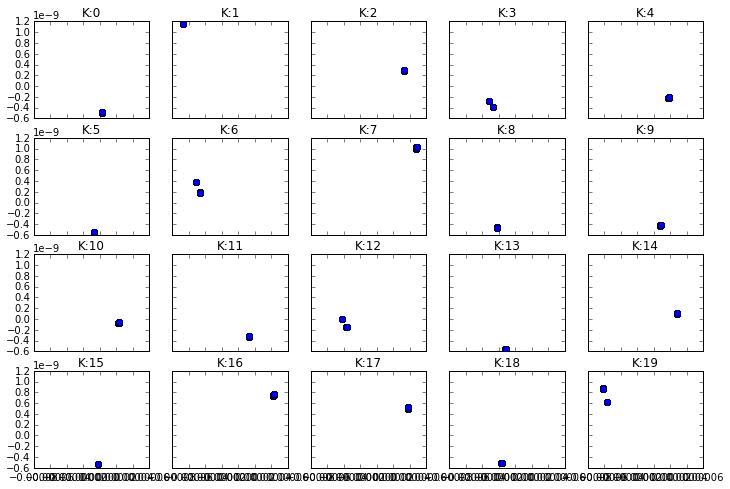

In [55]:
def plot_clusters():
    ''' Show all clusters in individual scatterplots '''
    f, axarr = plt.subplots(4, 5, sharex=True, sharey=True)
    le = MultiColumnLabelEncoder()
    nrm = Normalizer()
    imp = Imputer()
    tr = train_raw[['X','Y','TimeOfDay','YearQtr']].copy()
    pl = Pipeline([('le',le),('imp',imp),('nrm',nrm)])
    tr = pl.fit_transform(tr)
    pca = PCA(n_components=2)
    X = pca.fit_transform(tr)
    K = np.array(train_raw['KMcluster'])
    for i in range(20):
        if i<5: e=0
        elif i<10: e=1
        elif i<15: e=2
        else: e=3
        z = i - 5*e
        axarr[e, z].plot(X[K==i,0]\
                            ,X[K==i,1]\
                            ,'bo')
        axarr[e, z].set_title('K:{}'.format(i))
        plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
        plt.setp([a.get_yticklabels() for a in axarr[:, 1]], visible=False)

plot_clusters()

In [56]:
def transform_address(x):
    x = re.sub(r'[0-9\/]','',x)
    x = x.upper()
    x = x.split()
    x = sorted(set(x))
    #removes = ['OF',' ','AV','ST','BL','CT','WY'\
    #           ,'DR','PL','RD','LN','TR','CR','TH'\
    #           ,'THE','BLOCK','HY','BLVD']
    removes = ['OF','THE','TH',' ']
    x = [ z for z in x if z not in removes ]
    x = ' '.join(x)
    x = re.sub(r'\ \ ',' ',x)
    x = re.sub(r'^\ ','',x)
    return x

transform_address = np.vectorize(transform_address)
train_raw['AddressMod'] = transform_address(train_raw['Address'])

### Part 3: Get data from other sources

SF OpenData has a ton of supplemental data sources that will be great to try out for this effort.  

NOTE: one of them is actually a list of crimes that seems to match data in the training set. I will NOT use that data to train my model or match against the test dataset; however, I believe that many contestants are doing this, given that there is a very clear separation in scores that indicates to me that maybe there is some cheating happening.

In [57]:
# http://spatialreference.org/ref/epsg/2227/
p = Proj('+proj=lcc +init=EPSG:2227 +datum=NAD83 +units=us-ft +no_defs',preserve_units=True)
convert_vals = np.vectorize(lambda x,y: p(x,y))
convert_vals_inv = np.vectorize(lambda x,y: p(x,y,inverse=True))

In [58]:
shpfilename_elect = 'Data/SanFranciscoElectricityUse/SanFranciscoElectricityUse.shp'
shpfilename_school = 'Data/schools_public_pt/schools_public_pt.shp'
shpfilename_neighborhoods = 'Data/planning_neighborhoods/planning_neighborhoods.shp'
shpfilename_jobdensity = 'Data/SanFranciscoJobDensity/SanFranciscoJobDensity.shp'
shpfilename_income = 'Data/SanFranciscoIncome/SanFranciscoIncome.shp'
shpfilename_sfpdplots = 'Data/sfpd_plots/sfpd_plots.shp'
shpfilename_sfpdsectors = 'Data/sfpd_sectors/sfpd_sectors.shp'
shpfilename_employment = 'Data/SanFranciscoEmploymentRate/SanFranciscoEmploymentRate.shp'
shpfilename_speeding = 'Data/SanFranciscoSpeedLimitCompliance/SanFranciscoSpeedLimitCompliance.shp'
street_tree_locations = 'Data/Street_Tree_List.csv'
report311_locations = 'Data/All_cases_map_view.csv'
business_locations = 'Data/Registered_Business_Map.csv'
park_locations = 'Data/Park_and_Open_Space_Map.csv'
offstreet_parking_locations = 'Data/Off-street_parking_lots_and_parking_garages_map.csv'

#### Convert lat/lon to coordinates that match shape files

In [59]:
train_raw['New_X'], train_raw['New_Y'] = \
    convert_vals(train_raw['X'],train_raw['Y'])
test_raw['New_X'], test_raw['New_Y'] = \
    convert_vals(test_raw['X'],test_raw['Y'])

In [60]:
pair_fields = ['New_X','New_Y','X','Y']
base_pairs = pd.concat([train_raw[pair_fields]\
                                 ,test_raw[pair_fields]])
logger.info('Base pairs prior to duplicate removal: {}'.format(base_pairs.shape[0]))
base_pairs = base_pairs.drop_duplicates()
logger.info('Base pairs after duplicate removal: {}'.format(base_pairs.shape[0]))
base_points = [ Point((x,y)) for x,y in zip(base_pairs['New_X'],base_pairs['New_Y']) ]

INFO:root:Base pairs prior to duplicate removal: 2676929
INFO:root:Base pairs after duplicate removal: 39776


#### Read and process CSVs

In [61]:
'''
trees = pd.read_csv(street_tree_locations)
report311 = pd.read_csv(report311_locations)
businesses = pd.read_csv(business_locations)
parks = pd.read_csv(park_locations, quotechar = "\"")
offstreet_parking = pd.read_csv(offstreet_parking_locations)
'''

'\ntrees = pd.read_csv(street_tree_locations)\nreport311 = pd.read_csv(report311_locations)\nbusinesses = pd.read_csv(business_locations)\nparks = pd.read_csv(park_locations, quotechar = """)\noffstreet_parking = pd.read_csv(offstreet_parking_locations)\n'

In [62]:
def getll(x):
    ''' Get lat/lon for 311 and parking file '''
    try:
        x = re.sub(r'[\(\)]','',x)
        x = x.split(', ')
        return float(x[0]),float(x[1])
    except:
        return (None,None)

In [63]:
'''
offstreet_parking['LatLon'] = offstreet_parking['Location 1'].apply(getll)
offstreet_parking['X'],offstreet_parking['Y'] = \
    offstreet_parking['LatLon'].apply(lambda x: x[1])\
    ,offstreet_parking['LatLon'].apply(lambda x: x[0])
offstreet_parking['XCoord'], offstreet_parking['YCoord'] = \
    convert_vals(offstreet_parking['X'],offstreet_parking['Y'])
'''

"\noffstreet_parking['LatLon'] = offstreet_parking['Location 1'].apply(getll)\noffstreet_parking['X'],offstreet_parking['Y'] =     offstreet_parking['LatLon'].apply(lambda x: x[1])    ,offstreet_parking['LatLon'].apply(lambda x: x[0])\noffstreet_parking['XCoord'], offstreet_parking['YCoord'] =     convert_vals(offstreet_parking['X'],offstreet_parking['Y'])\n"

In [64]:
'''
report311['Datetime'] = pd.to_datetime(report311['Opened']
                                 ,format='%m/%d/%Y %H:%M:%S %p')
report311['LatLon'] = report311['Point'].apply(getll)
report311['X'],report311['Y'] = \
    report311['LatLon'].apply(lambda x: x[1])\
    ,report311['LatLon'].apply(lambda x: x[0])
'''

"\nreport311['Datetime'] = pd.to_datetime(report311['Opened']\n                                 ,format='%m/%d/%Y %H:%M:%S %p')\nreport311['LatLon'] = report311['Point'].apply(getll)\nreport311['X'],report311['Y'] =     report311['LatLon'].apply(lambda x: x[1])    ,report311['LatLon'].apply(lambda x: x[0])\n"

In [65]:
def getll(x):
    ''' Get lat/lon for park & business file '''
    try:
        x = x.split('\n')[2]
        x = re.sub(r'[\(\)]','',x)
        x = x.split(', ')
        return float(x[0]),float(x[1])
    except:
        return (None,None)

In [66]:
'''
parks['LatLon'] = parks['Location 1'].apply(getll)
parks['X'] = parks['LatLon'].apply(lambda x: x[1])
parks['Y'] = parks['LatLon'].apply(lambda x: x[0])
parks['XCoord'], parks['YCoord'] = convert_vals(parks['X'],parks['Y'])
'''

"\nparks['LatLon'] = parks['Location 1'].apply(getll)\nparks['X'] = parks['LatLon'].apply(lambda x: x[1])\nparks['Y'] = parks['LatLon'].apply(lambda x: x[0])\nparks['XCoord'], parks['YCoord'] = convert_vals(parks['X'],parks['Y'])\n"

In [67]:
'''
businesses['LatLon'] = businesses['Business_Location'].apply(getll)
businesses['X'] = businesses['LatLon'].apply(lambda x: x[1])
businesses['Y'] = businesses['LatLon'].apply(lambda x: x[0])
businesses['XCoord'], businesses['YCoord'] = convert_vals(businesses['X'],businesses['Y'])
businesses_class02 = businesses.loc[businesses['Class Code']=='02',['XCoord','YCoord']]
businesses_class07 = businesses.loc[businesses['Class Code']=='07',['XCoord','YCoord']]
businesses_class08 = businesses.loc[businesses['Class Code']=='08',['XCoord','YCoord']]
'''

"\nbusinesses['LatLon'] = businesses['Business_Location'].apply(getll)\nbusinesses['X'] = businesses['LatLon'].apply(lambda x: x[1])\nbusinesses['Y'] = businesses['LatLon'].apply(lambda x: x[0])\nbusinesses['XCoord'], businesses['YCoord'] = convert_vals(businesses['X'],businesses['Y'])\nbusinesses_class02 = businesses.loc[businesses['Class Code']=='02',['XCoord','YCoord']]\nbusinesses_class07 = businesses.loc[businesses['Class Code']=='07',['XCoord','YCoord']]\nbusinesses_class08 = businesses.loc[businesses['Class Code']=='08',['XCoord','YCoord']]\n"

#### Process 311 file based on time of call
This process only matches based on timestamp - and the 311 calls data only covers about 1/2 of the total timeframe that the crimes dataset covers. Some extra processing will be needed to impute values for other years.

In [68]:
def match311(x,dat311):
    ''' Match 311 calls within 1 hour 
        of crimes
        
        Note: ignoring distance because 
        of time constraints.
    '''
    x_new = x.copy()
    dts = np.array(x_new).astype(np.datetime64)
    ''' Ignore point distances 
    X = np.array(x_new['X'])
    Y = np.array(x_new['Y'])
    XY_311 = [ Point((x,y)) for x,y in zip(dat311['X'],dat311['Y']) ]
    '''
    out = np.empty(len(x_new))
    ts_311 = np.array(dat311['Datetime'])
    ts_311_m1 = ts_311 + np.timedelta64(-6,'h')
    ts_311_p1 = ts_311 + np.timedelta64(1,'h')
    for i in range(dts.shape[0]):
        s = np.empty((ts_311.shape[0],2))
        s[:,0] = (dts[i] >= ts_311_m1)
        s[:,1] = (dts[i] <= ts_311_p1)
        #s[:,2] = (1000 >= np.array([ arcdist(Point((X[i],Y[i])),p) \
        #                               for p in XY_311 ]))
        z = np.min(s,axis=1)
        out[i] = np.sum(z)
    return out

In [69]:
filename='Data/matched_311_all.csv'
'''
x_dat = train_raw[train_raw['Dates'].dt.year>=2008]['Dates'].drop_duplicates()
logger.info('Starting abandoned vehicle 311 matching')
matched_311_abandoncar = match311(x_dat\
                       ,report311[report311['Category']=='Abandoned Vehicle'])
logger.info('Starting damaged property 311 matching')
matched_311_dmgprop = match311(x_dat\
                       ,report311[report311['Category']=='Damaged Property'])
logger.info('Starting streetlight 311 matching')
matched_311_streetlights = match311(x_dat\
                       ,report311[report311['Category']=='Streetlights'])

logger.info('Finishing 311 matching')
matched_311_all = pd.DataFrame({'Abandoned Vehicle 311':matched_311_abandoncar\
                               ,'Damaged Property 311':matched_311_dmgprop\
                               ,'Streetlights 311':matched_311_streetlights})
matched_311_all['Date'] = x_dat['Dates']
matched_311_all.to_csv(filename)
'''
matched_311_all = pd.read_csv(filename,index_col=0,header=0)

### Functions to find matches to crimes from supplemental data sources, based on location

NOTE: Ideally these data sources would have some temporal element as well; however, most of them only contain data for a single time snapshot that is roughly in the middle of all the crimes data - better than nothing, but not ideal.

#### Read shapefiles and store properties into pandas dataframe

In [70]:
def read_speeding():
    ''' Process speeding rates into pandas dataframe '''
    shp = fiona.open(shpfilename_speeding)
    n = len(shp)
    Over_pct,\
    O5mph_pct,\
    Speed_avg = \
        np.empty(n,dtype=np.float),\
        np.empty(n,dtype=np.float),\
        np.empty(n,dtype=np.float)
    for i,s in enumerate(shp):
        Over_pct[i] = s['properties']['Over_pct']
        O5mph_pct[i] = s['properties']['O5mph_pct']
        Speed_avg[i] = s['properties']['Speed_avg']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],\
            'Over_pct':Over_pct,\
            'O5mph_pct':O5mph_pct,\
            'Speed_avg':Speed_avg
        })
    return props_df

# props_df_speeding = read_speeding()

In [71]:
def read_employment():
    ''' Process employment rates into pandas dataframe '''
    shp = fiona.open(shpfilename_employment)
    n = len(shp)
    Employ_pct,\
    Employ_moe = \
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        Employ_pct[i] = s['properties']['Employ_pct']
        Employ_moe[i] = s['properties']['Employ_moe']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],\
            'Employ_pct':Employ_pct,\
            'Employ_moe':Employ_moe
        })
    return props_df

props_df_employment = read_employment()

DEBUG:Fiona:Index: 0


In [72]:
def read_sfpdsectors():
    ''' Process SFPD sectors into pandas dataframe '''
    shp = fiona.open(shpfilename_sfpdsectors)
    n = len(shp)
    SECTORID = \
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        SECTORID[i] = s['properties']['SECTORID']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'SECTORID':SECTORID
        })
    return props_df

props_df_sfpdsectors = read_sfpdsectors()

DEBUG:Fiona:Index: 0


In [73]:
def read_sfpdplots():
    ''' Process SFPD plot into pandas dataframe '''
    shp = fiona.open(shpfilename_sfpdplots)
    n = len(shp)
    PLOT = \
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        PLOT[i] = s['properties']['PLOT']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'PLOT':PLOT
        })
    return props_df

props_df_sfpdplots = read_sfpdplots()

DEBUG:Fiona:Index: 0


In [74]:
def read_neighborhoods():
    ''' Process neighborhood file into pandas dataframe '''
    shp = fiona.open(shpfilename_neighborhoods)
    n = len(shp)
    NEIGHBORHO = \
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        NEIGHBORHO[i] = s['properties']['neighborho']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'NEIGHBORHO':NEIGHBORHO
        })
    return props_df

props_df_neighborhood = read_neighborhoods()

DEBUG:Fiona:Index: 0


In [75]:
def read_income():
    ''' Process income file into pandas dataframe '''
    shp = fiona.open(shpfilename_income)
    n = len(shp)
    MedInc_d,\
    MedInc_moe,\
    pC_Inc_d,\
    pC_Inc_moe = \
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        MedInc_d [i] = s['properties']['MedInc_d']
        MedInc_moe [i] = s['properties']['MedInc_moe']
        pC_Inc_d [i] = s['properties']['pC_Inc_d']
        pC_Inc_moe [i] = s['properties']['pC_Inc_moe']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'MedInc_d':MedInc_d,
            'MedInc_moe':MedInc_moe,
            'pC_Inc_d':pC_Inc_d,
            'pC_Inc_moe':pC_Inc_moe
        })
    return props_df

props_df_income = read_income()

DEBUG:Fiona:Index: 0


In [76]:
def read_jobdensity():
    ''' Process job density file into pandas dataframe '''
    shp = fiona.open(shpfilename_jobdensity)
    n = len(shp)
    JOBS_PSMI,\
    JOBS_CNT = \
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        JOBS_PSMI [i] = s['properties']['Jobs_psmi']
        JOBS_CNT [i] = s['properties']['Jobs_cnt']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'JOBS_PSMI':JOBS_PSMI,
            'JOBS_CNT':JOBS_CNT
        })
    return props_df

props_df_jobs = read_jobdensity()

DEBUG:Fiona:Index: 0


In [77]:
def read_schoolfile():
    ''' Process school file into pandas dataframe '''
    shp = fiona.open(shpfilename_school)
    n = len(shp)
    SCHOOL_TYP,\
    DEPT,\
    FACILITY_N,\
    DEPTNAME,\
    FACILITY_I = \
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25'),\
        np.empty(n,dtype='|S25')
    for i,s in enumerate(shp):
        SCHOOL_TYP[i] = s['properties']['SCHOOL_TYP']
        DEPT [i] = s['properties']['DEPT']
        FACILITY_N [i] = s['properties']['FACILITY_N']
        DEPTNAME [i] = s['properties']['DEPTNAME']
        FACILITY_I [i] = s['properties']['FACILITY_I']
    shp.close()
    props_df = pd.DataFrame({
            'Id':[i+1 for i in range(n)],
            'SCHOOL_TYP':SCHOOL_TYP
        })
    return props_df

props_df_schools = read_schoolfile()

DEBUG:Fiona:Index: 0


In [78]:
def read_electfile():
    shp = fiona.open(shpfilename_elect)
    n = len(shp)
    kWh_pC,\
    kWh,\
    Zip,\
    Pop2010_zc = \
        np.empty(n,dtype=np.float64),\
        np.empty(n,dtype=np.float64),\
        np.empty(n,dtype='|S10'),\
        np.empty(n,dtype=np.int64)
    for i,s in enumerate(shp):
        kWh_pC[i] = s['properties']['kWh_pC']
        kWh [i] = s['properties']['kWh']
        Zip [i] = s['properties']['Zip']
        Pop2010_zc [i] = s['properties']['Pop2010_zc']
    shp.close()

    props_df_elect = pd.DataFrame({
            'Id':[i+1 for i in range(n)],\
            'kWh_pC':kWh_pC,\
            'kWh':kWh,\
            'Zip':Zip,\
            'Pop2010_zc':Pop2010_zc\
        })
    return props_df_elect

props_df_elect = read_electfile()

DEBUG:Fiona:Index: 0


##### Polygon search functions

In [79]:
def polygon_search(shpfilename):
    ''' Iterate through shapefile polygons
        and find id of polygon for 
        each datapoint if it fits inside 
        of the polygon boundaries
    '''
    shp = pysal.open(shpfilename,'r')
    pl = PolygonLocator([p for p in shp])
    shp.close()
    return pl

##### Centroid search function (faster than polygon search)

In [80]:
def coord_search_centroid(shpfile,\
                 locator_fun=BruteForcePointLocator):
    ''' Since polygon search is not very efficient
        when there are many polygons, instead
        do a comparison to each polygon centroid 
    '''
    logger.info('Gathering centroids')
    gather_centroids = lambda shp: [p.centroid for p in shp]

    # Read file
    shp = pysal.open(shpfile,'r')
    centroids = gather_centroids(shp)
    pl = locator_fun(centroids)
    shp.close()
    
    return pl,centroids

##### Functions that iterate over each observation and match GIS data points
These functions are used to divide the workload among multiple processors. Since the tasks are very CPU-bound and can be run separately then compiled afterward, this works quite well.

In [81]:
def run_iters_points(points, point_locator, \
              proximity=100,log_at=100000):
    ''' Iterate through points and return number
        of points in surrounding proximity
    '''
    point_fun = lambda x,pl: pl.proximity(x,proximity)
    surrounding_pts = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: logger.info('running {0} row'.format(i))
        pts = point_fun(p,point_locator)
        surrounding_pts[i] = len(pts)
    return surrounding_pts

In [82]:
def run_iters_point_distance(points, point_locator\
            ,log_at=100000):
    ''' Iterate through points and return distance
        to the nearest point
    '''
    point_fun = lambda x,pl: pl.nearest(x)
    distances = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: logger.info('running {0} row'.format(i))
        pt = point_fun(p,point_locator)
        distances[i] = arcdist(p,pt)
    return distances

In [83]:
def run_iters_poly(points, point_locator\
                   ,log_at=100000):
    ''' Iterate through points and find matching polygon '''
    
    def return_poly_id(pl,x):
        ''' Find the polygon within the 
            PolygonLocator that 
            matches to each point
        '''
        try:
            return pl.contains_point(x)[0].id
        except IndexError:
            return -1
    
    poly_ids = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: logger.info('running {0} row'.format(i))
        poly_ids[i] = return_poly_id(point_locator,p)
    return poly_ids

In [84]:
def run_iters_centroid(points, point_locator, centroids, \
              log_at=1000):
    ''' Iterate through points to find 
        the nearest matching polygon centroid point
        
        Faster than running polygon search 
    '''
    logger.info('Running iterations on {} points'.format(len(points)))
    point_fun = lambda x,pl: pl.nearest(x)
    id_fun = lambda p, centroids: [i for i,c in enumerate(centroids)\
                                  if c==p][0]
    nearest_ids = np.zeros(len(points),dtype=np.int64)
    for i,p in enumerate(points):
        if i%log_at==0: logger.info('running {0} row'.format(i))
        pt = point_fun(p,point_locator)
        pt_id = id_fun(pt, centroids)
        nearest_ids[i] = pt_id
    return nearest_ids

##### Multiprocessing function to distribute work over many cores

In [85]:
def do_workload(worker,base_points,n_threads=2):
    ''' Create subprocess threads and combine work 
        after finishing.
        
        NOTE: freezes in ipython notebook
    '''
    n = n_threads
    # multiprocessing.freeze_support()
    pool = multiprocessing.Pool(n)
    
    p = [ i*len(base_points)//n for i in range(n+1) ]

    points_list = [ base_points[p[i]:p[i+1]] for i in range(n) ]
    points_list += [base_points[p[n]:]]

    res = pool.map(worker, points_list)
    pool.close()
    pool.join()
    x = pd.concat(res,axis=0)
    return x

#### Match crimes data to supplementary data sources

The core of the work below was done on other machines, or on my laptop but outside of ipython notebook due to issues with parallel processing. In most cases, the code that was run is commented out, other than reading in the data from the files that were already processed. 

Most the matching is done based on lat/lon coordinates, which are not at all unique for each crime. In fact, only about 1.5% of the lat/lon coordinates are unique compared to the total number of crimes in the file.

##### Find nearby schools

In [86]:
def search_schools(pts):
    ''' Find nearest point and measure distance
        for every datapoint 
    '''
    hs = props_df_schools[props_df_schools['SCHOOL_TYP']=='High School']['Id']
    cs = props_df_schools[props_df_schools['SCHOOL_TYP']=='County School']['Id']
    chs = props_df_schools[props_df_schools['SCHOOL_TYP']=='Charter School']['Id']
    ms = props_df_schools[props_df_schools['SCHOOL_TYP']=='Middle School']['Id']
    em = props_df_schools[props_df_schools['SCHOOL_TYP']=='Elementary']['Id']
    
    shp = pysal.open(shpfilename_school,'r')
    pl_hs = BruteForcePointLocator([p for p in shp if p.id in hs])
    pl_cs = BruteForcePointLocator([p for p in shp if p.id in cs])
    pl_chs = BruteForcePointLocator([p for p in shp if p.id in chs])
    pl_ms = BruteForcePointLocator([p for p in shp if p.id in ms])
    pl_em = BruteForcePointLocator([p for p in shp if p.id in em])
    shp.close()

    return_point_hs = lambda x: pl_hs.nearest(x)
    return_point_cs = lambda x: pl_cs.nearest(x)
    return_point_chs = lambda x: pl_chs.nearest(x)
    return_point_ms = lambda x: pl_ms.nearest(x)
    return_point_em = lambda x: pl_em.nearest(x)
    
    # point_ids = np.zeros(len(points),dtype=np.int8)
    point_distances_hs = np.zeros(len(pts),dtype=np.float64)
    point_distances_cs = np.zeros(len(pts),dtype=np.float64)
    point_distances_chs = np.zeros(len(pts),dtype=np.float64)
    point_distances_ms = np.zeros(len(pts),dtype=np.float64)
    point_distances_em = np.zeros(len(pts),dtype=np.float64)
    
    def run_iters():
        for i,p in enumerate(pts):
            if i%1000==0: logger.info('running {0} row'.format(i))
            pt_hs = return_point_hs(p)
            pt_cs = return_point_cs(p)
            pt_chs = return_point_chs(p)
            pt_ms = return_point_ms(p)
            pt_em = return_point_em(p)
            
            point_distances_hs[i] = arcdist(p,pt_hs)
            point_distances_cs[i] = arcdist(p,pt_cs)
            point_distances_chs[i] = arcdist(p,pt_chs)
            point_distances_ms[i] = arcdist(p,pt_ms)
            point_distances_em[i] = arcdist(p,pt_em)

    run_iters()
    
    return point_distances_hs,\
            point_distances_cs,\
            point_distances_chs,\
            point_distances_ms,\
            point_distances_em

'''
point_distances_hs,\
            point_distances_cs,\
            point_distances_chs,\
            point_distances_ms,\
            point_distances_em = search_schools(base_points)
schools = pd.DataFrame({'high school nearby':point_distances_hs\
                       ,'county school nearby':point_distances_cs\
                       ,'charter school nearby':point_distances_chs\
                       ,'middle school nearby':point_distances_ms\
                       ,'elementary school nearby':point_distances_em})
schools['X'],schools['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
schools.to_csv('Data/schools.csv')
'''
schools = pd.read_csv('Data/schools.csv',header=0,index_col=0)

##### Find nearby parking lots

In [87]:
filename='Data/parking.csv'
'''
offstreet_parking_points = [ Point((x,y)) for x,y in zip(offstreet_parking['XCoord'],offstreet_parking['YCoord']) ]
def worker(points):
    return pd.DataFrame({'nearest_parkinglot_distance':run_iters_point_distance(points\
                                  ,BruteForcePointLocator(offstreet_parking_points)\
                                  ,log_at=100000)})
logger.info('Starting work on parking lots')
x = do_workload(worker,base_points,8)
x['X'],x['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x.to_csv(filename,index=True)
'''
parkinglots = pd.read_csv(filename,index_col=0,header=0)

##### Process park CSV and find if park is nearby 

In [88]:
filename='Data/parks.csv'
'''
park_points = [ Point((x,y)) for x,y in zip(parks['XCoord'],parks['YCoord']) ]
def worker(points):
    return pd.DataFrame({'nearest_park_distance':run_iters_point_distance(points\
                                  ,BruteForcePointLocator(park_points)\
                                  ,log_at=100000)})
logger.info('Starting work on parks')
x = do_workload(worker,base_points,8)
x['X'],x['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x.to_csv(filename,index=True)
'''
parks = pd.read_csv(filename,index_col=0,header=0)

##### Process major business classes nearby 

In [89]:
filename02='Data/business_classes02.csv'
filename07='Data/business_classes07.csv'
filename08='Data/business_classes08.csv'
'''
bus02_points = [ Point((x,y)) for x,y in zip(businesses_class02['XCoord'],businesses_class02['YCoord']) ]
bus07_points = [ Point((x,y)) for x,y in zip(businesses_class07['XCoord'],businesses_class07['YCoord']) ]
bus08_points = [ Point((x,y)) for x,y in zip(businesses_class08['XCoord'],businesses_class08['YCoord']) ]
def worker02(points):
    return pd.DataFrame({'nearest_business_distance_02class':run_iters_point_distance(points\
                                  ,BruteForcePointLocator(bus02_points)\
                                  ,log_at=1000)})
def worker07(points):
    return pd.DataFrame({'nearest_business_distance_07class':run_iters_point_distance(points\
                                  ,BruteForcePointLocator(bus07_points)\
                                  ,log_at=1000)})
def worker08(points):
    return pd.DataFrame({'nearest_business_distance_08class':run_iters_point_distance(points\
                                  ,BruteForcePointLocator(bus08_points)\
                                  ,log_at=1000)})

x02 = do_workload(worker02,base_points,8)
x02['X'],x02['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x02.to_csv(filename02,index=True)

x07 = do_workload(worker07,base_points,8)
x07['X'],x07['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x07.to_csv(filename07,index=True)

x08 = do_workload(worker08,base_points,8)
x08['X'],x08['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x08.to_csv(filename08,index=True)
'''
business_class02 = pd.read_csv(filename02,index_col=0,header=0)
business_class07 = pd.read_csv(filename07,index_col=0,header=0)
business_class08 = pd.read_csv(filename08,index_col=0,header=0)

##### Find neighborhood of crime

In [90]:
filename='Data/neighborhoods.csv'
'''
neighborhood_locator = polygon_search(shpfilename_neighborhoods)
def worker(points):
    return pd.DataFrame({'neighborhood_id':run_iters_poly(points\
                                    ,neighborhood_locator
                                    ,log_at=10000)})

logger.info('Starting work on neighborhood')
x = do_workload(worker,base_points,8)
x['X'],x['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x.to_csv(filename,index=True)
'''
neighborhoods = pd.read_csv(filename,index_col=0,header=0)

##### Add SFPD Sectors

In [91]:
filename='Data/sfpd_sectors.csv'
'''
sfpdsector_locator = polygon_search(shpfilename_sfpdsectors)
def worker(points):
    return pd.DataFrame({'sfpd_sector_id':run_iters_poly(points\
                                    ,sfpdsector_locator
                                    ,log_at=10000)})

logger.info('Starting work on SFPD Sectors')
x = do_workload(worker,base_points,8)
x['X'],x['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x.to_csv(filename,index=True)
'''
sfpd_sectors = pd.read_csv(filename,index_col=0,header=0)

##### Add SFPD plots

In [92]:
filename='Data/sfpd_plots.csv'
'''
sfpdplot_locator = polygon_search(shpfilename_sfpdplots)
def worker(points):
    return pd.DataFrame({'sfpd_plot_id':run_iters_poly(points\
                                    ,sfpdplot_locator
                                    ,log_at=10000)})

logger.info('Starting work on SFPD Plots')
x = do_workload(worker,base_points,8)
x['X'],x['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x.to_csv(filename,index=True)
'''
sfpd_plots = pd.read_csv(filename,index_col=0,header=0)

##### Process tree CSV and find number of trees nearby to crime

In [93]:
filename='Data/trees_wxy.csv'
''' 
tree_points = [ Point((x,y)) for x,y in zip(trees['XCoord'],trees['YCoord']) ]

def worker(points):
    return pd.DataFrame({'trees':run_iters_points(points\
                                  ,BruteForcePointLocator(tree_points)\
                                  ,proximity=100
                                  ,log_at=1000)})

x = do_workload(worker,base_points,8)
x.to_csv(filename,index=True)
'''
trees = pd.read_csv(filename,index_col=0,header=0)

##### Process jobs data

In [94]:
filename = 'Data/job_ids.csv'
'''
jobzone_locator = polygon_search(shpfilename_jobdensity)
def worker(points):
    return pd.DataFrame({'job_id':run_iters_poly(points\
                                    ,jobzone_locator
                                    ,log_at=10000)})

logger.info('Starting work on job zones')
x = do_workload(worker,base_points,8)
x['X'],x['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x.to_csv(filename,index=True)
'''
jobs = pd.read_csv(filename,index_col=0,header=0)

##### Process employment data

In [95]:
filename = 'Data/employment.csv'
'''
employment_locator = polygon_search(shpfilename_employment)
def worker(points):
    return pd.DataFrame({'employment_id':run_iters_poly(points\
                                    ,employment_locator
                                    ,log_at=10000)})

logger.info('Starting work on employment zones')
x = do_workload(worker,base_points,8)
x['X'],x['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x.to_csv(filename,index=True)
'''
employment = pd.read_csv(filename,index_col=0,header=0)

##### Process income data

In [96]:
filename='Data/income.csv'
'''
income_locator,centroids = coord_search_centroid(shpfilename_income)

def worker(points):
    return pd.DataFrame({'income_id':run_iters_centroid(points\
                                    ,income_locator
                                    ,centroids
                                    ,log_at=10000)})

logger.info('Starting work on incomes')
x = do_workload(worker,base_points,8)
x['X'],x['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x.to_csv(filename,index=True)
'''
incomes = pd.read_csv(filename,index_col=0,header=0)

##### Process electricity usage data

In [97]:
filename='Data/electricity.csv'
'''
elect_locator,centroids = coord_search_centroid(shpfilename_elect)

def worker(points):
    return pd.DataFrame({'electricity_id':run_iters_centroid(points\
                                    ,elect_locator
                                    ,centroids
                                    ,log_at=10000)})

logger.info('Starting work on electricity')
x = do_workload(worker,base_points,8)
x['X'],x['Y'] = np.array(base_pairs['X']),np.array(base_pairs['Y'])
x.to_csv(filename,index=True)
'''
electricity = pd.read_csv(filename,index_col=0,header=0)

### Add new columns
Datasets matched by location:
* incomes
* employment
* jobs
* trees
* neighborhoods
* business_class02
* business_class07
* business_class08
* parks
* schools
* sfpd_plots
* sfpd_sectors
* electricity

Matched by timestamp:
* matched_311_all

In [77]:
keep_fields = [#'IncidntNum',
                 'Category',
                 #'Descript',
                 'DayOfWeek',
                 #'Date',
                 #'Time',
                 'PdDistrict',
                 #'Resolution',
                 #'Address',
                 'X',
                 'Y',
                 #'Location',
                 #'PdId',
                 'Dates',
                 'collar_id',
                 'DaySegment',
                 'TimeOfDay',
                 'DayOfMonth',
                 'Year',
                 'Month',
                 'YearQtr',
                 'YearSegment',
                 'KMcluster',
                 'KMdistance',
                 'AddressMod',
                 #'New_X',
                 #'New_Y'
              ]
train_raw = train_raw[keep_fields]

In [78]:
'''
incomes = incomes.drop_duplicates(subset=['X','Y'],take_last=True)
employment = employment.drop_duplicates(subset=['X','Y'],take_last=True)
jobs = jobs.drop_duplicates(subset=['X','Y'],take_last=True)
trees = trees.drop_duplicates(subset=['X','Y'],take_last=True)
neighborhoods = neighborhoods.drop_duplicates(subset=['X','Y'],take_last=True)
business_class02 = business_class02.drop_duplicates(subset=['X','Y'],take_last=True)
business_class07 = business_class07.drop_duplicates(subset=['X','Y'],take_last=True)
business_class08 = business_class08.drop_duplicates(subset=['X','Y'],take_last=True)
parks = parks.drop_duplicates(subset=['X','Y'],take_last=True)
schools = schools.drop_duplicates(subset=['X','Y'],take_last=True)
sfpd_plots = sfpd_plots.drop_duplicates(subset=['X','Y'],take_last=True)
sfpd_sectors = sfpd_sectors.drop_duplicates(subset=['X','Y'],take_last=True)
electricity = electricity.drop_duplicates(subset=['X','Y'],take_last=True)
matched_311_all = matched_311_all.drop_duplicates(subset='Date', take_last=True)
'''

"\nincomes = incomes.drop_duplicates(subset=['X','Y'],take_last=True)\nemployment = employment.drop_duplicates(subset=['X','Y'],take_last=True)\njobs = jobs.drop_duplicates(subset=['X','Y'],take_last=True)\ntrees = trees.drop_duplicates(subset=['X','Y'],take_last=True)\nneighborhoods = neighborhoods.drop_duplicates(subset=['X','Y'],take_last=True)\nbusiness_class02 = business_class02.drop_duplicates(subset=['X','Y'],take_last=True)\nbusiness_class07 = business_class07.drop_duplicates(subset=['X','Y'],take_last=True)\nbusiness_class08 = business_class08.drop_duplicates(subset=['X','Y'],take_last=True)\nparks = parks.drop_duplicates(subset=['X','Y'],take_last=True)\nschools = schools.drop_duplicates(subset=['X','Y'],take_last=True)\nsfpd_plots = sfpd_plots.drop_duplicates(subset=['X','Y'],take_last=True)\nsfpd_sectors = sfpd_sectors.drop_duplicates(subset=['X','Y'],take_last=True)\nelectricity = electricity.drop_duplicates(subset=['X','Y'],take_last=True)\nmatched_311_all = matched_311_a

In [79]:
def create_mergekey(df):
    ''' I had problems using pandas
        merge on two float keys,
        so I am creating a single 
        string mergekey and it works   
    ''' 
    return (df['X'] * 10000000000).astype(str),(df['Y'] * 10000000000).astype(str)

def mergekeys():
    logger.info('Creating mergekeys')
    train_raw['X_merge'],train_raw['Y_merge'] = create_mergekey(train_raw)
    train_raw['Datemerge'] = train_raw['Dates'].astype(str)
    test_raw['X_merge'],test_raw['Y_merge'] = create_mergekey(test_raw)
    test_raw['Datemerge'] = test_raw['Dates'].astype(str)
    incomes['X_merge'],incomes['Y_merge'] = create_mergekey(incomes)
    jobs['X_merge'],jobs['Y_merge'] = create_mergekey(jobs)
    trees['X_merge'],trees['Y_merge'] = create_mergekey(trees)
    neighborhoods['X_merge'],neighborhoods['Y_merge'] = create_mergekey(neighborhoods)
    business_class02['X_merge'],business_class02['Y_merge'] = create_mergekey(business_class02)
    business_class07['X_merge'],business_class07['Y_merge'] = create_mergekey(business_class07)
    business_class08['X_merge'],business_class08['Y_merge'] = create_mergekey(business_class08)
    parks['X_merge'],parks['Y_merge'] = create_mergekey(parks)
    schools['X_merge'],schools['Y_merge'] = create_mergekey(schools)
    electricity['X_merge'],electricity['Y_merge'] = create_mergekey(electricity)
    employment['X_merge'],employment['Y_merge'] = create_mergekey(employment)
    matched_311_all['Datemerge'] = matched_311_all['Date'].astype(str)
 
mergekeys()

INFO:root:Creating mergekeys


In [80]:
def merge_all():
    for i,df in enumerate([train_raw,test_raw]):
        t = 'train' if i==0 else 'test'
        
        logger.info('Merging income for {}'.format(t))
        logger.info('Pre datasize: {}'.format(len(df)))
        df = pd.merge(df,incomes[['income_id'\
                                   ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left',copy=False)

        logger.info('Merging jobs for {}'.format(t))
        df = pd.merge(df,jobs[['job_id'\
                                ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left')

        logger.info('Merging trees for {}'.format(t))
        df = pd.merge(df,trees[['trees'\
                                  ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left',copy=False)

        logger.info('Merging neighborhoods for {}'.format(t))
        df = pd.merge(df,neighborhoods[['neighborhood_id'\
                                        ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left',copy=False)

        logger.info('Merging parks for {}'.format(t))
        df = pd.merge(df,parks[['nearest_park_distance'\
                                ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left',copy=False)

        logger.info('Merging business class 02 for {}'.format(t))
        df = pd.merge(df,business_class02[\
                                        ['nearest_business_distance_02class'\
                                         ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left',copy=False)

        logger.info('Merging business class 07 for {}'.format(t))
        df = pd.merge(df,business_class07[['nearest_business_distance_07class'\
                                            ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left',copy=False)

        logger.info('Merging business class 08 for {}'.format(t))
        df = pd.merge(df,business_class08[['nearest_business_distance_08class'\
                                           ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left',copy=False)

        logger.info('Merging electricity for {}'.format(t))
        df = pd.merge(df,electricity[['electricity_id'\
                                      ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left',copy=False)

        logger.info('Merging employment for {}'.format(t))
        df = pd.merge(df,employment[['employment_id'\
                                      ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left',copy=False)

        logger.info('Merging schools for {}'.format(t))
        df = pd.merge(df,schools[['charter school nearby'\
                                    ,'county school nearby'\
                                    ,'elementary school nearby'\
                                    ,'high school nearby'\
                                    ,'middle school nearby'\
                                    ,'X_merge','Y_merge']]\
                             ,on=['X_merge','Y_merge'],how='left',copy=False)

        logger.info('Merging electricity props for {}'.format(t))
        df = pd.merge(df,props_df_elect,left_on='electricity_id'\
                                      ,right_on='Id'\
                                      ,how='left'\
                                      ,copy=False)

        logger.info('Merging job props for {}'.format(t))
        df = pd.merge(df,props_df_jobs,left_on='job_id'\
                                      ,right_on='Id'\
                                      ,how='left'\
                                      ,copy=False)

        logger.info('Merging income props for {}'.format(t))
        df = pd.merge(df,props_df_income,left_on='income_id'\
                                      ,right_on='Id'\
                                      ,how='left'\
                                      ,copy=False)

        logger.info('Merging employment props for {}'.format(t))
        df = pd.merge(df,props_df_employment,left_on='employment_id'\
                                      ,right_on='Id'\
                                      ,how='left'\
                                      ,copy=False)

#         logger.info('Merging 311 calls for {}'.format(t))
#         df = pd.merge(df,matched_311_all,left_on='Datemerge'\
#                                       ,right_on='Datemerge'\
#                                       ,how='left'\
#                                       ,copy=False)
        
        logger.info('Post datasize: {}'.format(len(df)))
        logger.info('Saving {} data to disk'.format(t))
        filename = 'Data/merge_{}_all.csv'.format(t)
        df.to_csv(filename)

# merge_all()

### Modeling

In [14]:
train_raw = pd.read_csv('Data/merge_{}_all.csv'.format('train'),index_col=0)
test_raw = pd.read_csv('Data/merge_{}_all.csv'.format('test'),index_col=0)

In [16]:
model_fields = [#'Category',
                 'DayOfWeek',
                 'PdDistrict',
                 #'collar_id',
                 'DaySegment',
                 'TimeOfDay',
                 'DayOfMonth',
                 'YearQtr',
                 'KMcluster',
                 'KMdistance',
                 'AddressMod',
                 'trees',
                 'neighborhood_id',
                 'nearest_park_distance',
                 'nearest_business_distance_02class',
                 'nearest_business_distance_07class',
                 'nearest_business_distance_08class',
                 'electricity_id',
                 'employment_id',
                 'charter school nearby',
                 'county school nearby',
                 'elementary school nearby',
                 'high school nearby',
                 'middle school nearby',
                 'Pop2010_zc',
                 'Zip',
                 'kWh',
                 'kWh_pC',
                 'JOBS_CNT',
                 'JOBS_PSMI',
                 'MedInc_d',
                 'MedInc_moe',
                 'pC_Inc_d',
                 'pC_Inc_moe',
                 'Employ_moe',
                 'Employ_pct']
categorical_fields = [#'Category',
                 'DayOfWeek',
                 'PdDistrict',
                 #'collar_id',
                 'DaySegment',
                 'TimeOfDay',
                 'DayOfMonth',
                 'YearQtr',
                 'KMcluster',
                 'AddressMod',
                 'neighborhood_id']

In [17]:
tr = train_raw[model_fields+['collar_id','Category']].copy().iloc[\
                   np.random.permutation(len(train_raw))]
tr = tr.dropna()

In [20]:
train_raw.iloc[25]

Category                                                  LARCENY/THEFT
DayOfWeek                                                     Wednesday
PdDistrict                                                     SOUTHERN
X                                                             -122.3951
Y                                                              37.78599
Dates                                               2015-07-22 22:00:00
collar_id                                                             5
DaySegment                                                            6
TimeOfDay                                                            22
DayOfMonth                                                           22
Year                                                               2015
Month                                                                 7
YearQtr                                                          201502
YearSegment                                                     

In [83]:
logger.info('Sampling started')
tr = train_raw[model_fields+['collar_id','Category']].copy().iloc[\
                   np.random.permutation(len(train_raw))]
    
dev_train\
    , dev_train_labels_cid\
    , dev_train_labels_cat = tr[model_fields][50001:],\
                             tr['collar_id'][50001:],\
                                tr['Category'][50001:]
dev_test\
    , dev_test_labels_cid\
    , dev_test_labels_cat = tr[model_fields][:50000],\
                            tr['collar_id'][:50000],\
                            tr['Category'][:50001]

INFO:root:Sampling started


In [85]:
def make_pipeline():
    ''' Create pipeline that will be 
        used multiple times.
        
        Pipeline contains all necessary
        components of model run in 
        sequence. 
        
        SVD runs prior to a RandomForest model
        and creates a dense metrix. RF model
        outputs new dataset with most important
        features to LogisticRegression model.
        
        The same logic will be used twice:
        1) predict collar ID and then add 
            the prediction and corresponding
            prediction probability as features
            on the original dataset
        2) predict Category and use for 
            the next submission.
    '''
    le = MultiColumnLabelEncoder()
    cf = [i for i,x in enumerate(model_fields) if x in categorical_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=True)
    imp = Imputer()
    svd = TruncatedSVD(n_components=25) 
    rf = RandomForestClassifier(n_estimators=100,n_jobs=1)
    lr = LogisticRegression(C=0.1,solver='lbfgs'\
                            ,multi_class='multinomial')
    pl = Pipeline([('le',le)\
                   ,('ohe',ohe)\
                   ,('imp',imp)\
                   ,('svd',svd)\
                   ,('rf',rf)\
                   ,('lr',lr)]) 
                   
    return pl

pl = make_pipeline()

In [ ]:
def predict_metaclass():
    '''Predict the metaclass of crime
       Use the outputted algorithm to 
       predict metaclass in the training data
    '''
    
    logger.info('Creating pipeline')
    ''' GridSearch for optimal parameters
    logger.info('GV search started')
    param_grid = dict(md__C=[0.1,0.5,1,5])
    gs = GridSearchCV(pl, param_grid=param_grid, verbose=10)
    gs.fit(dev_train, dev_train_labels)
    logger.info('Best C parameter: {}'.format(gs.best_estimator_)) 
    logger.info('GV search ended')
    '''
    
    logger.info('Fitting training data') 
    pl.fit(dev_train, dev_train_labels_cid)
    
    logger.info('Model diagnostics started')
    logger.info('Model accuracy: {}%'.format(round(pl.score(dev_test, \
                                                 dev_test_labels_cid),4)*100))
    predictions = pl.predict(dev_test)
    conf = confusion_matrix(dev_test_labels_cid,predictions)
    plt.imshow(conf, cmap='binary',interpolation='nearest')
    print pd.crosstab(dev_test_labels_cid, predictions, \
                      rownames=['True'], colnames=['Predicted'], \
                      margins=True)
    return pl

logger.info('Model for collar_id started')
pl_metaclass = predict_metaclass()
logger.info('Model for collar_id ended')

INFO:root:Model for collar_id started
INFO:root:Creating pipeline
INFO:root:Fitting training data


In [115]:
print 'F1 Score: {}%'.format(round(f1_score(\
                    pl_metaclass.predict(dev_test)\
                    ,dev_test_labels_cid\
                    ,average='weighted')*100,2))
print classification_report(pl_metaclass.predict(dev_test)\
                    ,dev_test_labels_cid)

F1 Score: 16.27%
             precision    recall  f1-score   support

          1       0.04      0.16      0.06      1186
          2       0.70      0.04      0.07      7845
          3       0.28      0.02      0.04      5486
          4       0.33      0.18      0.24      5544
          5       0.21      0.43      0.28      7067
          6       0.28      0.24      0.26      8550
          7       0.15      0.26      0.19      4923
          8       0.33      0.05      0.09      7970
          9       0.02      0.11      0.04       889
         10       0.01      0.13      0.02       540

avg / total       0.33      0.17      0.16     50000



##### Add prediction and prediction score as a feature

Use the generated dev and test datasets from above in future modeling efforts, because otherwise the model will have been fit with test data and accuracy measures will have been thrown off.

In [ ]:
# le,ohe,imp,svd,md,rf = [ x[1] for x in pl_metaclass.steps[:5] ]

# tr = le.transform(dev_train)
# tr = ohe.transform(tr)
# tr = imp.transform(tr)
# tr = svd.transform(tr)
# tr = rf.transform(tr)
# tr = lr.transform(tr)
dev_train['cid_pred_score'] = \
    np.max(pl_metaclass.predict_proba(dev_train),axis=1)
dev_train['cid_prediction'] = pl_metaclass.predict(dev_train)

# tr = le.transform(dev_test)
# tr = ohe.transform(tr)
# tr = imp.transform(tr)
# tr = svd.transform(tr)
dev_test['cid_pred_score'] = \
    np.max(md.predict_proba(tr),axis=1)
dev_test['cid_prediction'] = pl_metaclass.predict(tr)

# tr = le.transform(test_raw[model_fields])
# tr = ohe.transform(tr)
# tr = imp.transform(tr)
# tr = svd.transform(tr)
test_raw['cid_pred_score'] = \
    #np.max(md.decision_function(tr),axis=1)
    np.max(md.predict_proba(tr),axis=1)
test_raw['cid_prediction'] = pl_metaclass.predict(tr)

In [ ]:
def add_knnguess():
    knn = KNeighborsClassifier(n_neighbors=20)
    le = MultiColumnLabelEncoder()
    imp = Imputer(strategy='mean')
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=True)
    svd = TruncatedSVD(n_components=20) 
    pl = Pipeline([('le',le),('ohe',ohe),('svd',svd),('md',md)])
    
    pl.fit(dev_train, dev_train_labels)
    train_raw['KNNguess'] = pl.predict(train_raw[new_fields])
    test_raw['KNNguess'] = pl.predict(test_raw[new_fields])

add_knnguess()

##### Use the LR model to output a new set of data for the final model

In [ ]:
dev_train_aftermodel = p1_metaclass.transform(dev_train)
dev_test_aftermodel = p1_metaclass.transform(dev_test)
test_raw_aftermodel = p1_metaclass.transform(test_raw)

##### Test performance

In [ ]:
def runmodel():
    new_fields = [
        'PdDistrict','DaySegment',\
        'kWh','Zip','Pop2010_zc','Year','KMcluster'
    ]
    cat_fields = [
        'PdDistrict','DayOfWeek','DaySegment','TimeOfDay','DayOfMonth','Year',\
        'Zip','KMcluster',\
        'ZONING_SIM','DISTRICT_NAME','ZONE_ID','KNNguess'
    ]

    le = MultiColumnLabelEncoder()
    imp = Imputer(strategy='mean')
    cf = [i for i,x in enumerate(new_fields) if x in cat_fields]
    ohe = OneHotEncoder(categorical_features=cf,sparse=True)
    pca = PCA(n_components = 100)
    #md = MultinomialNB(alpha=0.01)
    md = LogisticRegression(C=0.1,solver='lbfgs',\
                            multi_class='multinomial')
    pl = Pipeline([('le',le), ('imp',imp), ('ohe', ohe), ('pca',pca), ('rf', rf)])

    pl.fit(dev_train, dev_train_labels,rf__sample_weight=dev_train_weights)
    print 'Accuracy: {0}%'.format(round(pl.score(dev_test, dev_test_labels),4)*100)
    return pl 

# pl = runmodel()

In [ ]:
def show_pca():
    exp_var = np.cumsum(pl.named_steps['pca'].explained_variance_ratio_)
    n = len(exp_var)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_title('PCA explained variance')
    ax.set_xlabel('Feature number')
    ax.set_ylabel('Explained Variance')
    ax.plot(range(n),exp_var,'-', linewidth=2)

    plt.show()

# show_pca()

##### Make another submission

In [ ]:
def save_testdata():
    test_raw.to_csv('Data/test_raw_nf.csv',index=False)

# save_testdata()

In [ ]:
# predictions = pl.predict(test_raw[new_fields])

In [ ]:
def write_to_submissionfile():
    l = len(test_raw)
    submission = np.zeros((l,40),dtype=np.int32)
    submission[:,0] = range(l)
    cols = sorted(set(train_raw['Category']))
    for i,c in enumerate(cols):
        submission[:,i+1] = predictions == c

    submission_cols = ['Id']
    submission_cols.extend(cols)
    submission_df = pd.DataFrame(submission,columns=submission_cols)
    submission_df.head()

    submission_df.to_csv('Data/submission_file2.csv',index=False)
    
# write_to_submissionfile()

#### Part 3 - Error Diagnosis

In [ ]:
predictions = pl.predict(dev_test)
conf = confusion_matrix(dev_test_labels,predictions)
plt.imshow(conf, cmap='binary')
pd.crosstab(dev_test_labels, predictions, rownames=['True'], colnames=['Predicted'], margins=True)

#### Appendix: Cheaters

Virtually all of the test dataset is available publicly online, with a holdout of only ~70k records. My thoughts are that the competition conductors will test using data from the holdout set (or else they are very silly).

In [41]:
test_raw_clean = test_raw.drop_duplicates()
crimes = pd.read_csv('/Users/bshur/School/\
Machine Learning/Final Project/Data/\
SFPD_Incidents_-_from_1_January_2003.csv')
crimes['Dates'] = pd.to_datetime(crimes['Date']\
                                 +' '\
                                 +crimes['Time']\
                                 ,format='%m/%d/%Y %H:%M')
crimes_cleaned = crimes[['Dates','DayOfWeek'\
                         ,'PdDistrict','Address'\
                         ,'X','Y']].drop_duplicates()
crimes_matched = pd.merge(crimes_cleaned\
                          ,test_raw_clean\
                          ,how='inner'
                          ,on=['Dates','DayOfWeek'\
                               ,'PdDistrict','Address'\
                               ,'X','Y'])

In [45]:
print 'Test set count: {}\nMatched set count: {}\nDifference: {}'.format(\
                            test_raw_clean.shape[0]\
                            ,crimes_matched.shape[0]\
                            ,test_raw_clean.shape[0]\
                              -crimes_matched.shape[0])

Test set count: 884262
Matched set count: 815740
Difference: 68522
